<a id="import"></a>

In [1]:
import numpy as np
import pandas as pd


# Plotly Packages
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_letters

# Statistical Libraries
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats


# Regression Modeling
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# Other Libraries
import warnings
warnings.filterwarnings("ignore")

C:\Users\Serhii\AppData\Local\Temp\ipykernel_16144\3203409509.py:21: DeprecationWarning:

Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.



In [34]:
df = pd.read_csv("insurance.csv")
display(df.head())

# Let's store the original dataframe in another variable.
original_df = df.copy()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<h3> Distribution of Medical Charges </h3> 
<a id="distribution"></a>
<ul>
    <li><b>Types of Distributions: </b> We have a <b> right skewed distribution </b> in which most patients are being charged between $2000 - $12000.</li>
    <li><b>Using Logarithms:  </b> Logarithms helps us have a <b>normal distribution </b> which could help us in a number of different ways such as outlier detection, implementation of statistical concepts based on the central limit theorem and for our predictive modell in the foreseen future. (We will come to this later in the kernel) </li>
    </ul>

In [3]:
# Determine the distribution of charge
charge_dist = df["charges"].values
logcharge = np.log(df["charges"])



trace0 = go.Histogram(
    x=charge_dist,
    histnorm='probability',
    name="Charges Distribution",
    marker = dict(
        color = '#FA5858',
    )
)
trace1 = go.Histogram(
    x=logcharge,
    histnorm='probability',
    name="Charges Distribution using Log",
    marker = dict(
        color = '#58FA82',
    )
)

fig = tools.make_subplots(rows=2, cols=1,
                          subplot_titles=('Charge Distribution','Log Charge Distribution'),
                         print_grid=False)



fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)


fig['layout'].update(showlegend=True, title='Charge Distribution', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

### Age Analysis:
<a id="age_cat"></a>
<h4>Turning Age into Categorical Variables: </h4>
<ul> 
    <li><b>Young Adult: </b> from 18 - 35 </li>
    <li><b>Senior Adult: </b> from 36 - 55 </li>
    <li><b>Elder: </b> 56 or older </li>
    <li><b> Share of each Category: </b> Young Adults (42.9%), Senior Adults (41%) and Elder (16.1%) </li>
    </ul>

In [29]:
df['age_cat'] = np.nan
lst = [df]

for col in lst:
    col.loc[(col['age'] >= 18) & (col['age'] <= 35), 'age_cat'] = 'Young Adult'
    col.loc[(col['age'] > 35) & (col['age'] <= 55), 'age_cat'] = 'Senior Adult'
    col.loc[col['age'] > 55, 'age_cat'] = 'Elder'
    
    
labels = df["age_cat"].unique().tolist()
amount = df["age_cat"].value_counts().tolist()

colors = ["#ff0000", "#00ff00", " #0000ff"]

trace = go.Pie(labels=labels, values=amount,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))

data = [trace]
layout = go.Layout(title="Amount by Age Category")

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic_pie_chart')

<h3> Is there a Relationship between BMI and Age</h3>
<a id="bmi_age"></a>
<ul>
    <li><b>BMI frequency: </b> Most of the BMI frequency is concentrated between 27 - 33. </li>
    <li><b> Correlations </b> Age and charges have a correlation of 0.29 while bmi and charges have a correlation of 0.19 </li>
    <li><b> Relationship betweem BMI and Age: </b> The correlation for these two variables is 0.10 which is not that great. Therefore, we can disregard that age has a huge influence on BMI. </li>
    </ul>

In [30]:
bmi = [df["bmi"].values.tolist()]
group_labels = ['Body Mass Index Distribution']

colors = ['#FF0000']

fig = ff.create_distplot(bmi, group_labels, colors=colors)
# Add title
fig['layout'].update(title='Normal Distribution <br> Central Limit Theorem Condition')

iplot(fig, filename='Basic Distplot')

In [6]:
corr = df.corr()

hm = go.Heatmap(
    z=corr.values,
    x=corr.index.values.tolist(),
    y=corr.index.values.tolist()
)


data = [hm]
layout = go.Layout(title="Correlation Heatmap")

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

In [31]:
young_adults = df["bmi"].loc[df["age_cat"] == "Young Adult"].values
senior_adult = df["bmi"].loc[df["age_cat"] == "Senior Adult"].values
elders = df["bmi"].loc[df["age_cat"] == "Elder"].values

trace0 = go.Box(
    y=young_adults,
    name = 'Young Adults',
    boxmean= True,
)
trace1 = go.Box(
    y=senior_adult,
    name = 'Senior Adults',
    boxmean= True,
)

trace2 = go.Box(
    y=elders,
    name = 'Elders',
    boxmean= True,
)




data = [trace0, trace1, trace2]

layout = go.Layout(title="Body Mass Index <br> by Age Category", xaxis=dict(title="Age Category", titlefont=dict(size=16)),
                  yaxis=dict(title="Body Mass Index", titlefont=dict(size=16)))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

<h4> Comparing Independent Categorical Variables (ANOVA) </h4>
<a id="ANOVA"></a>
<ul>
    <li> <b> P-value: </b>The p-value being higher than 0.05 tells us that we take the Null hypothesis, meaning that there is no a significant change between the three age categories when it comes to Body Mass Index.</li>
    </ul>

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


moore_lm = ols("bmi ~ age_cat", data=df).fit()
print(moore_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     5.949
Date:                Fri, 26 May 2023   Prob (F-statistic):            0.00268
Time:                        21:26:31   Log-Likelihood:                -4311.2
No. Observations:                1338   AIC:                             8628.
Df Residuals:                    1335   BIC:                             8644.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [9]:
import plotly.graph_objs as go

ya_smoker = df["bmi"].loc[(df["age_cat"] == "Young Adult") & (df["smoker"] == "yes")].values
sa_smoker = df["bmi"].loc[(df["age_cat"] == "Senior Adult") & (df["smoker"] == "yes")].values
e_smoker = df["bmi"].loc[(df["age_cat"] == "Elder") & (df["smoker"] == "yes")].values

# Non-Smokers
ya_nonsmoker = df["bmi"].loc[(df["age_cat"] == "Young Adult") & (df["smoker"] == "no")].values
sa_nonsmoker = df["bmi"].loc[(df["age_cat"] == "Senior Adult") & (df["smoker"] == "no")].values
e_nonsmoker = df["bmi"].loc[(df["age_cat"] == "Elder") & (df["smoker"] == "no")].values

x_data = ['Young A. Smoker', 'Young A. Non-Smoker',
          'Senior A. Smoker', 'Senior A. Non-Smoker',
          'Elder Smoker', 'Elder Non-Smoker',]

y0 = ya_smoker
y1 = ya_nonsmoker
y2 = sa_smoker
y3 = sa_nonsmoker
y4 = e_smoker
y5 = e_nonsmoker

y_data = [y0,y1,y2,y3,y4,y5]

colors = ['rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
          'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
          'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Body Mass Index of Smokers Status by Age Category',
    xaxis=dict(
    title="Status",
    titlefont=dict(
    size=16)),
    yaxis=dict(
        title="Body Mass Index",
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
        titlefont=dict(
        size=16)
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 243, 192)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

### Who got charged more on Average by Age?
<a id="charged_age"></a>
<ul> 
    <li><b>Patient Charge Mean: </b> For <b>young adults </b> it is 7,944, for <b> Senior Adults </b> it is 14,785  and for the <b>elder</b> it is 18,795. </li>
     <li><b>Patient Charge Median: </b> For <b>young adults </b> it is 4,252, for <b> Senior Adults </b> it is 9,565  and for the <b>elder</b> it is 13,429. </li>
    <li> <b> Mean and the Median:</b> Sometimes we must be careful when using the mean since it is prone to be affected by outliers.</li>
    </ul>

In [10]:
# Mean could be affected easily by outliers or extreme cases.
# Means
avg_ya_charge = df["charges"].loc[df["age_cat"] == "Young Adult"].mean()
avg_sa_charge = df["charges"].loc[df["age_cat"] == "Senior Adult"].mean()
avg_e_charge = df["charges"].loc[df["age_cat"] == "Elder"].mean()

# Median
med_ya_charge = df["charges"].loc[df["age_cat"] == "Young Adult"].median()
med_sa_charge = df["charges"].loc[df["age_cat"] == "Senior Adult"].median()
med_e_charge = df["charges"].loc[df["age_cat"] == "Elder"].median()

average_plot = go.Bar(
    x=['Young Adults', 'Senior Adults', 'Elder'],
    y=[avg_ya_charge, avg_sa_charge, avg_e_charge],
    name='Mean',
    marker=dict(
        color="#F5B041"
    )
)
med_plot = go.Bar(
    x=['Young Adults', 'Senior Adults', 'Elder'],
    y=[med_ya_charge, med_sa_charge, med_e_charge],
    name='Median',
    marker=dict(
        color="#48C9B0"
    )
)


fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]],
                          subplot_titles=('Average Charge by Age','Median Charge by Age'),
                         shared_yaxes=True, print_grid=False)


fig.append_trace(average_plot, 1, 1)
fig.append_trace(med_plot, 1, 2)


fig['layout'].update(showlegend=True, title='Age Charges', xaxis=dict(title="Age Category"), yaxis=dict(title="Patient Charges"), bargap=0.15)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

### Weight Status:
https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html

<h4>Turning BMI into Categorical Variables: </h4>
<a id="bmi_cat"></a>
<ul>
    <li><b>Under Weight: </b> Body Mass Index (BMI) $<$ 18.5  </li>
    <li><b>Normal Weight: </b>  Body Mass Index (BMI) $\geq$ 18.5 and  Body Mass Index (BMI) $<$ 24.9 </li>
    <li><b>Overweight: </b>  Body Mass Index (BMI) $\geq$ 25 and  Body Mass Index (BMI) $<$ 29.9</li>
    <li><b>Obese: </b>  Body Mass Index (BMI) $>$ 30 </li>
    </ul>

In [11]:
df["weight_condition"] = np.nan
lst = [df]

for col in lst:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"
    
df.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,weight_condition
0,19,female,27.900,0,yes,southwest,16884.92400,Young Adult,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Young Adult,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Young Adult,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Young Adult,Normal Weight
4,32,male,28.880,0,no,northwest,3866.85520,Young Adult,Overweight


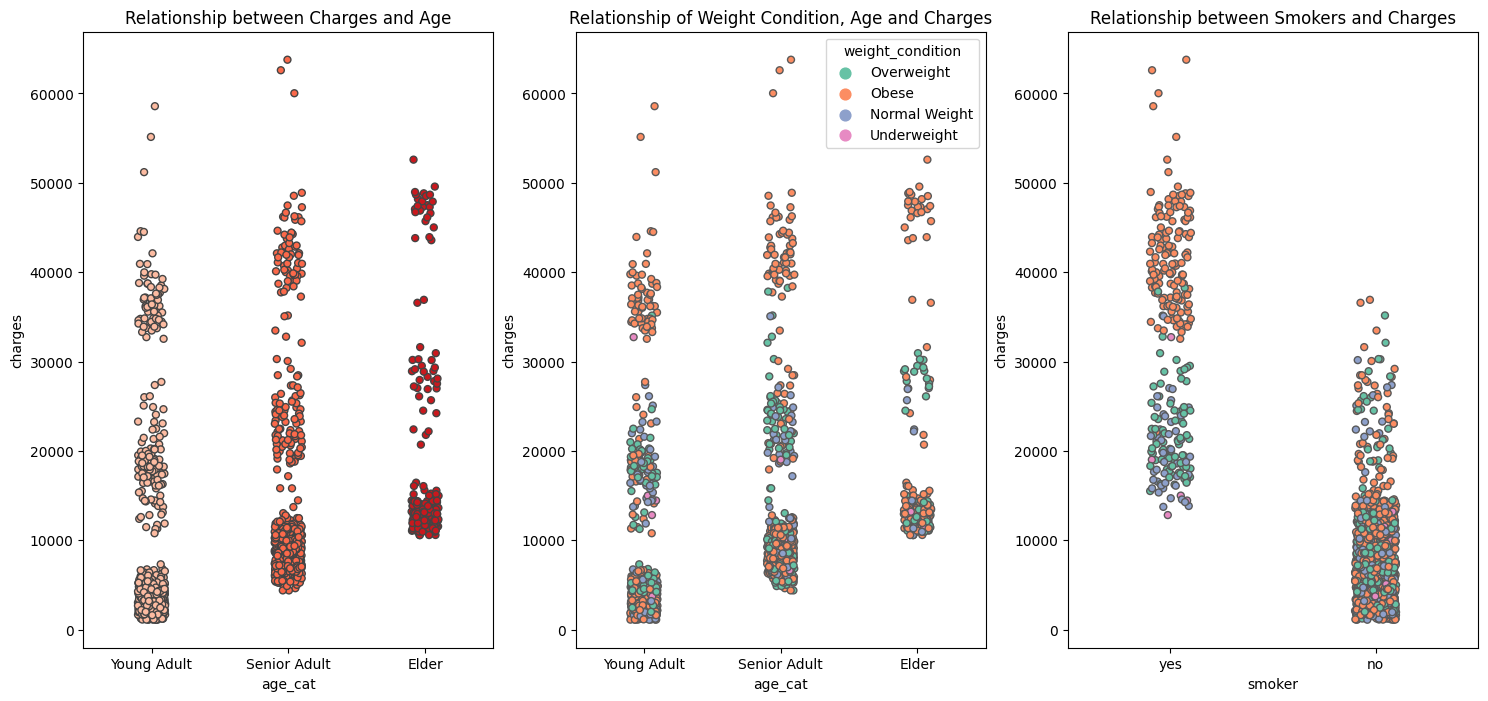

In [12]:
# Create subpplots
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,8))

# I wonder if the cluster that is on the top is from obese people
sns.stripplot(x="age_cat", y="charges", data=df, ax=ax1, linewidth=1, palette="Reds")
ax1.set_title("Relationship between Charges and Age")


sns.stripplot(x="age_cat", y="charges", hue="weight_condition", data=df, ax=ax2, linewidth=1, palette="Set2")
ax2.set_title("Relationship of Weight Condition, Age and Charges")

sns.stripplot(x="smoker", y="charges", hue="weight_condition", data=df, ax=ax3, linewidth=1, palette="Set2")
ax3.legend_.remove()
ax3.set_title("Relationship between Smokers and Charges")

plt.show()

In [13]:
# Make sure we don't have any null values
df[df.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges,age_cat,weight_condition


<h3> Weight Status vs Charges</h3>
<a id="weight_charges"></a>

<ul>
    <li> <b>Overweight: </b> Notice how there are two groups of people that get significantly charged more than the other group of overweight people. </li>
    <li><b>Obese: </b> Same thing goes with the obese group, were a significant group is charged more than the other group. </li>
    </ul>
    
**    Hmmm, might the smoking status have to do with this phenomenon?**<br> Let's find out!

In [14]:
fig = ff.create_facet_grid(
    df,
    x='age',
    y='charges',
    color_name='weight_condition',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'Underweight': 'rgb(208, 246, 130)', 'Normal Weight': 'rgb(166, 246, 130)',
             'Overweight': 'rgb(251, 232, 238)', 'Obese': 'rgb(253, 45, 28)'}
)
251, 232, 238


fig['layout'].update(title="Weight Status vs Charges", width=800, height=600, plot_bgcolor='rgb(251, 251, 251)', 
                     paper_bgcolor='rgb(255, 255, 255)')


iplot(fig, filename='facet - custom colormap')

In [15]:
# First find the average or median of the charges obese people paid.

obese_avg = df["charges"].loc[df["weight_condition"] == "Obese"].mean()

df["charge_status"] = np.nan
lst = [df]


for col in lst:
    col.loc[col["charges"] > obese_avg, "charge_status"] = "Above Average"
    col.loc[col["charges"] < obese_avg, "charge_status"] = "Below Average"
    
df.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,weight_condition,charge_status
0,19,female,27.900,0,yes,southwest,16884.92400,Young Adult,Overweight,Above Average
1,18,male,33.770,1,no,southeast,1725.55230,Young Adult,Obese,Below Average
2,28,male,33.000,3,no,southeast,4449.46200,Young Adult,Obese,Below Average
3,33,male,22.705,0,no,northwest,21984.47061,Young Adult,Normal Weight,Above Average
4,32,male,28.880,0,no,northwest,3866.85520,Young Adult,Overweight,Below Average


In [16]:
# No Nulls
df["charge_status"].isnull().sum()

0

<h3> Obesity and the Impact of Smoking to the Wallet: </h3>
<a id="obese_smoker"> </a>
<ul> 
    <li> Notice in the <b> charges </b> box how smoking looks to have a certain impact on medical costs.</li>
    <li> Let's find out how much of a difference there is between the group of <b> obese </b> patients that smoke compared to the group of <b> obese </b> patients that don't smoke.</li>
    </ul>

Text(0.5, 1.0, 'Smokers')

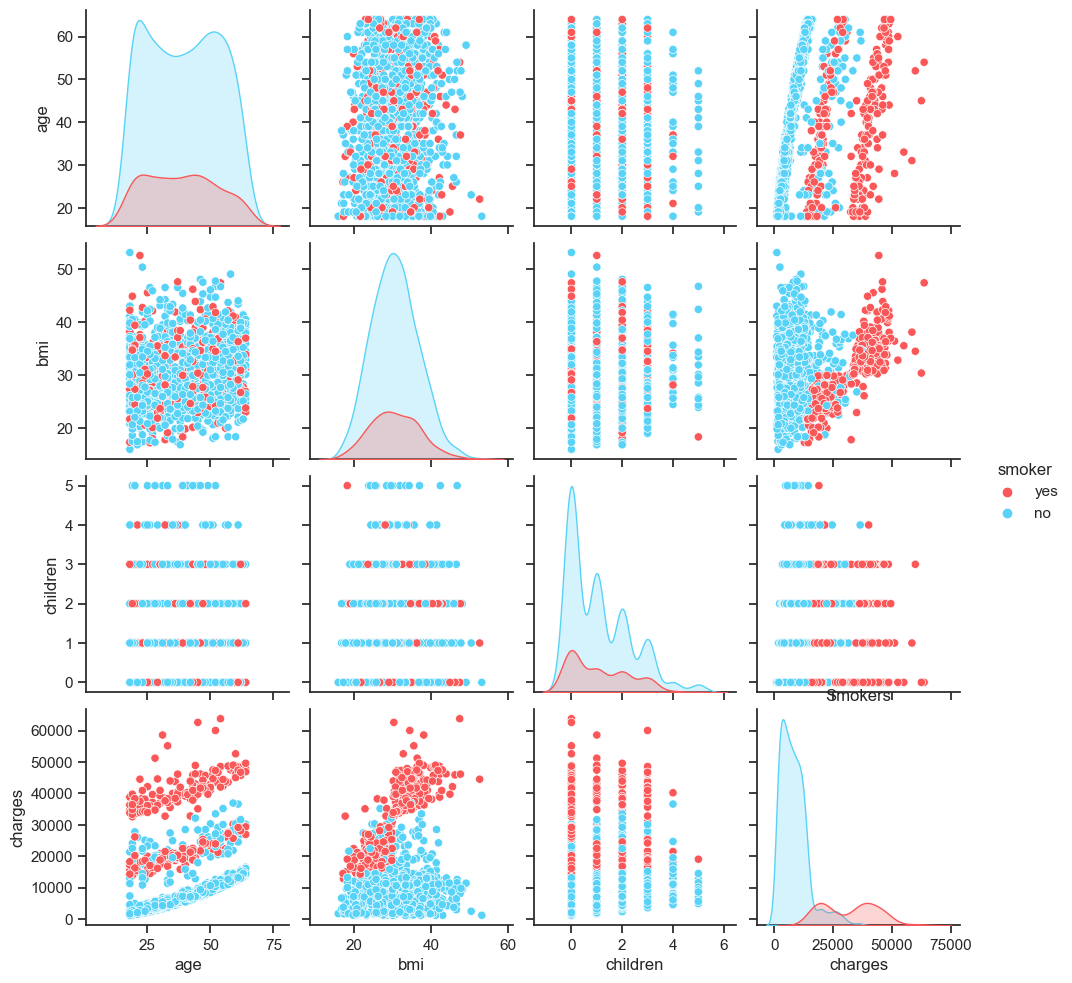

In [17]:
import seaborn as sns
sns.set(style="ticks")
pal = ["#FA5858", "#58D3F7"]

sns.pairplot(df, hue="smoker", palette=pal)
plt.title("Smokers")

In [18]:
# What Percentage of Obese that Smoked Paid aBove Average from the total obese patients?
# 79% of Obese were non-smokers while the 21% left were smokers
total_obese = len(df.loc[df["weight_condition"] == "Obese"])

obese_smoker_prop = len(df.loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "yes")])/total_obese
obese_smoker_prop = round(obese_smoker_prop, 2)

obese_nonsmoker_prop = len(df.loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "no")])/total_obese
obese_nonsmoker_prop = round(obese_nonsmoker_prop, 2)


# Average charge by obese_smokers and obese_nonsmoker
charge_obese_smoker = df.loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "yes")].mean()
charge_obese_nonsmoker = df.loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "no")].mean()

<h4>Distribution of Charges (Obese Smoker vs Obese non-Smoker) </h4>
<a id="obesevsnonobese_smokers"></a>
<ul> 
    <li><b>Violin Plots: </b> We will be using violin plots to <b>compare the distributions of patients of the obese group who are smokers and non-smokers. </b> </li>
    <li><b> Obese smokers distribution: </b> Most obese smokers pay around 40k in medical costs! </li>
    <li> <b>Obese non-smokers distribution: </b> Most obese non-smokers pay 8k in medical costs. </li>
    <li> <b> Smoking a factor to the wallet </b> Smoking is defninitely a big factor for obese patients when it comes to medical cost. A difference of more than 30k!</li>
    </ul>

In [19]:

pointspossmoker = [-0.9,-1.1,-0.6,-0.3]
pointposnonsmoker = [0.45,0.55,1,0.4]
showLegend = [True,False,False,False]

data = []
for i in range(0,len(pd.unique(df['weight_condition']))):
    male = {
            "type": 'violin',
            "x": df['weight_condition'][ (df['smoker'] == 'yes') & (df['weight_condition'] == pd.unique(df['weight_condition'])[i]) ],
            "y": df['charges'][ (df['smoker'] == 'yes') & (df['weight_condition'] == pd.unique(df['weight_condition'])[i]) ],
            "legendgroup": 'Smoker',
            "scalegroup": 'Smoker',
            "name": 'Smoker',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "points": 'all',
            "pointpos": pointspossmoker[i],
            "jitter": 0,
            "scalemode": 'count',
            "meanline": {
                "visible": True
            },
            "line": {
                "color": '#DF0101'
            },
            "marker": {
                "line": {
                    "width": 2,
                    "color": '#F78181'
                }
            },
            "span": [
                0
            ],
            "showlegend": showLegend[i]
        }
    data.append(male)
    female = {
            "type": 'violin',
            "x": df['weight_condition'] [ (df['smoker'] == 'no') & (df['weight_condition'] == pd.unique(df['weight_condition'])[i]) ],
            "y": df['charges'] [ (df['smoker'] == 'no') & (df['weight_condition'] == pd.unique(df['weight_condition'])[i]) ],
            "legendgroup": 'Non-Smoker',
            "scalegroup": 'Non-Smoker',
            "name": 'Non-Smoker',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "points": 'all',
            "pointpos": pointposnonsmoker[i],
            "jitter": 0,
            "scalemode": 'count',
            "meanline": {
                "visible": True
            },
            "line": {
                "color": '#00FF40'
            },
            "marker": {
                "line": {
                    "width": 2,
                    "color": '#81F781'
                }
            },
            "span": [
                0
            ],
            "showlegend": showLegend[i]
        }
    data.append(female)
        

fig = {
    "data": data,
    "layout" : {
        "title": "Charges Distribution of Obese Patients<br><i>Group by Smoking Status",
        "yaxis": {
            "zeroline": False,
            "title": "Patient Charges",
            "titlefont": {
                "size": 16
            }
        },
        "violingap": 0,
        "violingroupgap": 0,
        "violinmode": "overlay"
    }
}


iplot(fig, filename='violin/advanced', validate = False)

In [20]:
# Hmmm we have to look closer into Obsese there is an obvious difference

chargedist_sm = df["charges"].loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "yes")].values
chargedist_nsm = df["charges"].loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "no")].values

trace0 = go.Box(
    y=chargedist_sm,
    name = 'Obese Smokers',
    marker = dict(
        color = '#DF0101',
    )
)
trace1 = go.Box(
    y=chargedist_nsm,
    name = 'Obese Non-Smokers',
    marker = dict(
        color = '#00FF40',
    )
)


data = [trace0, trace1]


layout = dict(title="Deeper Look into Obese condition by Smoking status",
             xaxis=dict(
             title="Status",
             titlefont=dict(
             size=16)),
             yaxis=dict(title="Patient Charges",
                       titlefont=dict(size=16)),
              )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

<h4>Separation in Charges between Obese Smokers vs Non-Obese Smokers </h4>
<a id="separation"></a>
In this chart we can visualize how can <b> separate</b> obese smokers and obese non-smokers into different <b> clusters </b> of groups. Therefore, we can say that smoking is a <b>characteristic</b> that definitely affects patient's charges.

In [21]:
# Create a Scatter Plot with all the Obese
obese_smoker = df.loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "yes")]
obese_nonsmoker = df.loc[(df["weight_condition"] == "Obese") & (df["smoker"] == "no")]


trace0 = go.Scatter(
    x = obese_smoker["age"].values,
    y = obese_smoker["charges"].values,
    name = 'Smokers',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = '#DF0101',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

trace1 = go.Scatter(
    x = obese_nonsmoker["age"].values,
    y = obese_nonsmoker["charges"].values,
    name = 'Non-Smokers',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = '#00FF40',
        line = dict(
            width = 2,
        )
    )
)

data = [trace0, trace1]

layout = dict(title = 'Clear Separation between Obese Smokers and Non-Smokers in Charges',
              yaxis = dict(zeroline = False,
                          title="Patient Charges",
                          titlefont=dict(size=16)),
              xaxis = dict(zeroline = False,
                          title="Age of the Patient",
                          titlefont=dict(
                          size=16))
             )

fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-scatter')

<h2 align="center"><b>Regional Analysis: </b></h2>
<h3> Building a Contingency Table: </h3>
<a id="building_contingency">

In [22]:
# Cont table by weight condition and sex
df.head()

region_smoker = pd.crosstab(df['smoker'], df['region']).apply(lambda x: x/x.sum() * 100)
region_smoker

region,northeast,northwest,southeast,southwest
smoker,,,,
no,79.320988,82.153846,75.0,82.153846
yes,20.679012,17.846154,25.0,17.846154


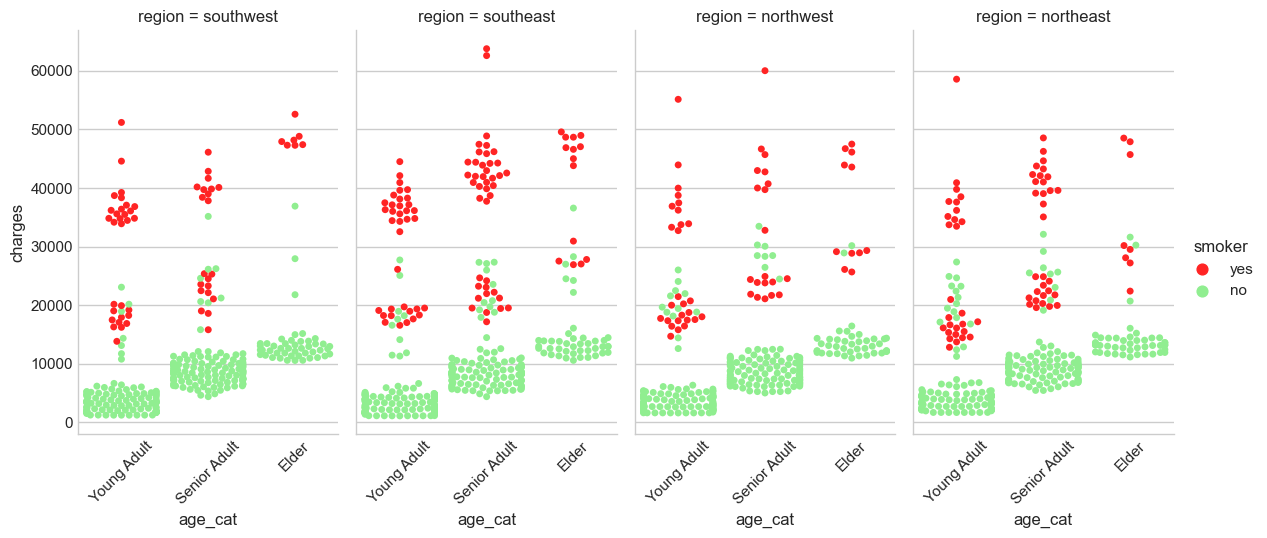

In [23]:
plt.style.use('seaborn-whitegrid')

ticks = df['age_cat'].unique()
colors = ['#ff2424', '#90ee90']


ax = sns.catplot(x="age_cat", y="charges", hue="smoker",
                 col="region", aspect=.6,
                 kind="swarm", palette=colors, data=df);

ax.set_xticklabels(labels = ticks, rotation=45)

plt.show()

In [24]:
# Obesity per region
region_weight = pd.crosstab(df['weight_condition'], df['region']).apply(lambda x: x/x.sum() * 100)
region_weight = round(region_weight, 2)
region_weight

region,northeast,northwest,southeast,southwest
weight_condition,,,,
Normal Weight,22.53,19.38,11.26,14.77
Obese,44.14,45.54,66.76,53.23
Overweight,30.25,32.92,21.98,31.08
Underweight,3.09,2.15,0.00,0.92


<h3>Average Patient Charge by Region: </h3>
<a id="average_region"></a>
<ul>
    <li><b> Median Patient Charges: </b> The <b>NorthEast</b> is the region that pays the most on average while the <b>SouthWest</b> is the one that pays </li>
    <li><b>Obese group: </b> From the obese group, the Southwest is the region where obese patients pay the most..</li>
    <li><b>Overweight: </b> From the obese group, the NorthWest is the region where obese patients pay the most.  </li>
    <li><b>Normal Weight: </b> From the obese group, the SouthEast is the region where obese patients pay the most.  </li>
    <li><b>Underweight: </b> From the obese group, the NorthWest is the region where obese patients pay the most.</li>
    </ul>

In [25]:
df.head()


# Average charge by Region
df["region"].unique()

# Median Charges per Region
southwest = np.median(df["charges"].loc[df["region"] == "southwest"].values)
southeast = np.median(df["charges"].loc[df["region"] == "southeast"].values)
northwest = np.median(df["charges"].loc[df["region"] == "northwest"].values)
northeast = np.median(df["charges"].loc[df["region"] == "northeast"].values)

lst = [southwest, southeast, northwest, northeast]

data = [go.Scatterpolar(
  r = [southwest, southeast, northwest, northeast],
  theta = ['SouthWest', 'SouthEast', 'NorthWest', 'NorthEast'],
  fill = 'toself'
)]

layout = go.Layout(
    title="Median Charged to Patients by Region",
    paper_bgcolor = "rgb(255, 255, 224)",
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, max(lst)]
    )
  ),
  showlegend = False
)


fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "radar/basic")

<h4>Average Charge by Region depending on the Weight Condition: </h4>
<a id="charge_condition"></a>


In [26]:
# Weight Condition by Region Radar plots

df["weight_condition"].unique()

# Average charges for overweight patients by region 
sw_overweight = np.mean(df["charges"].loc[(df["region"] == "southwest") & (df["weight_condition"] == "Overweight")].values)
se_overweight = np.mean(df["charges"].loc[(df["region"] == "southeast") & (df["weight_condition"] == "Overweight")].values)
nw_overweight = np.mean(df["charges"].loc[(df["region"] == "northwest") & (df["weight_condition"] == "Overweight")].values)
ne_overweight = np.mean(df["charges"].loc[(df["region"] == "northeast") & (df["weight_condition"] == "Overweight")].values)

# Obese
sw_obese = np.mean(df["charges"].loc[(df["region"] == "southwest") & (df["weight_condition"] == "Obese")].values)
se_obese = np.mean(df["charges"].loc[(df["region"] == "southeast") & (df["weight_condition"] == "Obese")].values)
nw_obese = np.mean(df["charges"].loc[(df["region"] == "northwest") & (df["weight_condition"] == "Obese")].values)
ne_obese = np.mean(df["charges"].loc[(df["region"] == "northeast") & (df["weight_condition"] == "Obese")].values)

# Normal Weight
sw_nw = np.mean(df["charges"].loc[(df["region"] == "southwest") & (df["weight_condition"] == "Normal Weight")].values)
se_nw = np.mean(df["charges"].loc[(df["region"] == "southeast") & (df["weight_condition"] == "Normal Weight")].values)
nw_nw = np.mean(df["charges"].loc[(df["region"] == "northwest") & (df["weight_condition"] == "Normal Weight")].values)
ne_nw = np.mean(df["charges"].loc[(df["region"] == "northeast") & (df["weight_condition"] == "Normal Weight")].values)

# Underweight
sw_uw = np.mean(df["charges"].loc[(df["region"] == "southwest") & (df["weight_condition"] == "Underweight")].values)
se_uw = np.mean(df["charges"].loc[(df["region"] == "southeast") & (df["weight_condition"] == "Underweight")].values)
nw_uw = np.mean(df["charges"].loc[(df["region"] == "northwest") & (df["weight_condition"] == "Underweight")].values)
ne_uw = np.mean(df["charges"].loc[(df["region"] == "northeast") & (df["weight_condition"] == "Underweight")].values)

# Labels
weight_labels = df["weight_condition"].unique().tolist()

# List per weight condition
sw_weights = [sw_overweight, sw_obese, sw_nw, sw_uw]
se_weights = [se_overweight, se_overweight, se_nw, se_uw]
nw_weights = [nw_overweight, nw_overweight, nw_nw, nw_uw]
ne_weights = [ne_overweight, ne_overweight, ne_nw, ne_uw]

data = [
    go.Scatterpolar(
        mode="lines+markers",
        r = sw_weights,
        theta = weight_labels,
        fill = 'toself',
        name="SouthWest",
        line=dict(
            color="rgba(0, 128, 128, 0.95)"
        ),
        marker=dict(
            color="rgba(0, 74, 147, 1)",
            symbol="square",
            size=8
        ),
        subplot = "polar"
    ),
    go.Scatterpolar(
        mode="lines+markers",
        r = se_weights,
        theta = weight_labels,
        fill = 'toself',
        name="SouthEast",
        line=dict(
            color="rgba(255, 72, 72, 0.95)"
        ),
        marker=dict(
            color="rgba(219, 0, 0, 1)",
            symbol="square",
            size=8
        ),
        subplot = "polar2"
    ),
    go.Scatterpolar(
        mode="lines+markers",
        r = nw_weights,
        theta = weight_labels,
        fill = 'toself',
        name="NorthWest",
        line=dict(
            color="rgba(72, 255, 72, 0.95)"
        ),
        marker=dict(
            color="rgba(0, 147, 74, 1)",
            symbol="square",
            size=8
        ),
        subplot = "polar3"
    ),
       go.Scatterpolar(
        mode="lines+markers",
        r = ne_weights,
        theta = weight_labels,
        fill = 'toself',
        name="NorthEast",
        line=dict(
            color="rgba(247, 133, 11, 0.95)"
        ),
        marker=dict(
            color="rgba(245, 168, 86, 1)",
            symbol="square",
            size=8
        ),
        subplot = "polar4"
    )
]

layout = go.Layout(
    title="Average Patient Charges <br> by Region <br>(Depending on the Patient's Weight Condition)",
    showlegend = False,
     paper_bgcolor = "rgb(252, 234, 161)",
    polar = dict(
      domain = dict(
        x = [0, 0.46],
        y = [0.56, 1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 40,
        direction = "clockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0, 0.46],
        y = [0, 0.44]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 40,
        direction = "clockwise"
      ),
    ),
    polar3 = dict(
      domain = dict(
       x = [0.54, 1],
        y = [0.56, 1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 40,
        direction = "clockwise"
      ),
    ),
        polar4 = dict(
      domain = dict(
        x = [0.54, 1],
        y = [0, 0.44]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 40,
        direction = "clockwise"
      ),
    ))

fig = go.Figure(data=data, layout=layout)
fig['layout'].update(height=800, width=800)
iplot(fig, filename='polar/directions')

<h2 align="center">Unsupervised Learning: </h2>
<h3>Performing Clustering in a Manual Way: </h3>
<a id="manual_cluster"></a>
In the first plot we will do a cluster analysis in a manual form and see what our eyes can discover. Here are the following results from the manual cluster analysis performed.
<ul>
    <li><b> Age and Charges: </b> We can see there is a slight increase in charges depending on the age of the patient. </li>
    <li><b> Obese Clusters: </b> We can see that for each age group there are clusters of the obese group in the top part of charges. </li>
    <li><b>Are these clusters Smokers? </b> As seen in the right chart, most of this clusters are definitely smokers.  </li>
    
</ul>

This is somewhat the same as we have explored in the previous section, but I wanted to add the factor of <b> age </b> to see until what extent this variable patient's charges. Nevertheless, we can still confirm that being obese and a smoker is the <b>grand major </b> factor at least for the group of obese and overweight patients. <br><br>

<b> Thanks to  Bhumika Bhatt for adding the factor of age with the combination of weight condition and smoking status </b>

Text(17, 40000, 'The Impact of Smoking to \n Charges on other \n Weight Conditions ')

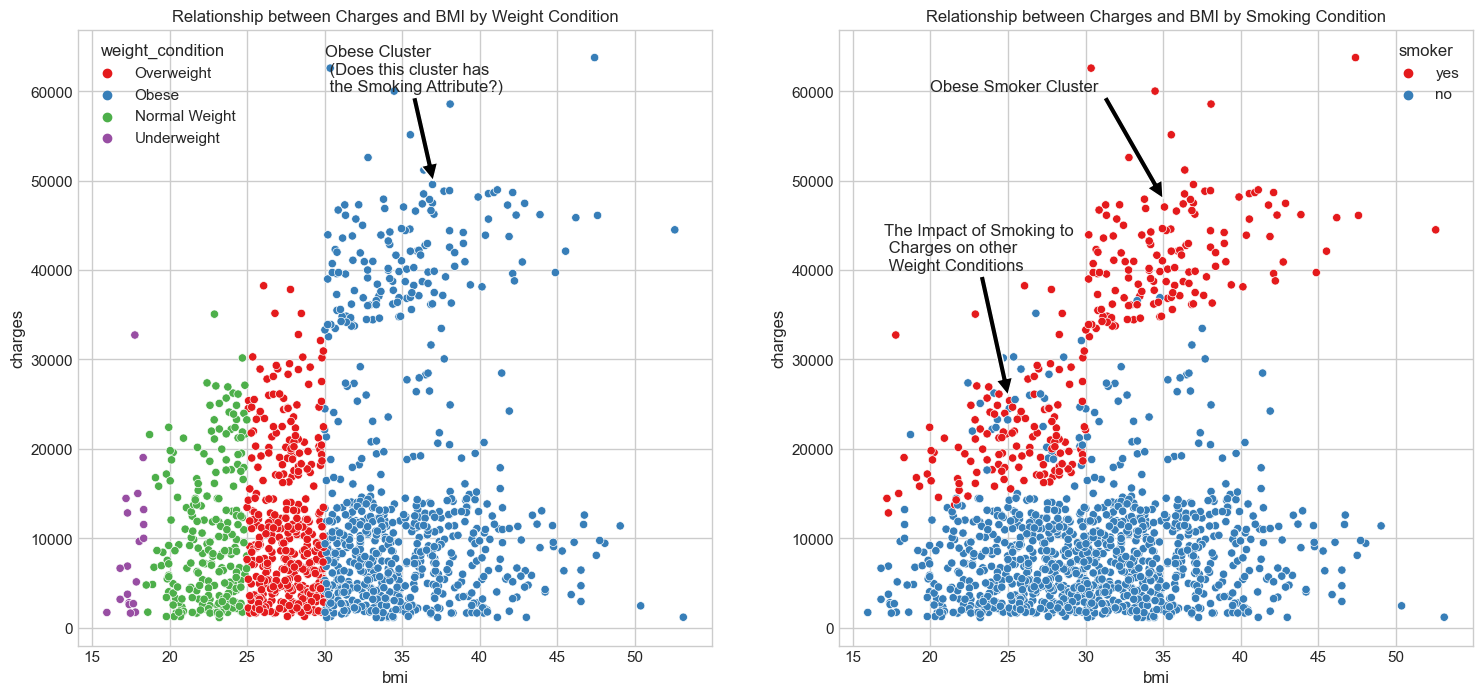

In [27]:
# Two subplots one with weight condition and the other with smoker.

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8))
sns.scatterplot(x="bmi", y="charges", hue="weight_condition", data=df, palette="Set1", ax=ax1)
ax1.set_title("Relationship between Charges and BMI by Weight Condition")
ax1.annotate('Obese Cluster \n (Does this cluster has \n the Smoking Attribute?)', xy=(37, 50000), xytext=(30, 60000),
            arrowprops=dict(facecolor='black'),
            fontsize=12)
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df, palette="Set1", ax=ax2)
ax2.set_title("Relationship between Charges and BMI by Smoking Condition")
ax2.annotate('Obese Smoker Cluster ', xy=(35, 48000), xytext=(20, 60000),
            arrowprops=dict(facecolor='black'),
            fontsize=12)
ax2.annotate('The Impact of Smoking to \n Charges on other \n Weight Conditions ', xy=(25, 26000), xytext=(17, 40000),
            arrowprops=dict(facecolor='black'),
            fontsize=12)